In [81]:
!pip install matplotlib


[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


Import relevant libraries

In [82]:
import numpy as np
import matplotlib.pyplot as plt

In [83]:
def assign_binary_label(x1,x2):
    #function y larger than 3x + 2
    if x2 > (0.6*x1 + 0.2):
        label = 0
    else:
        label = 1
    return label

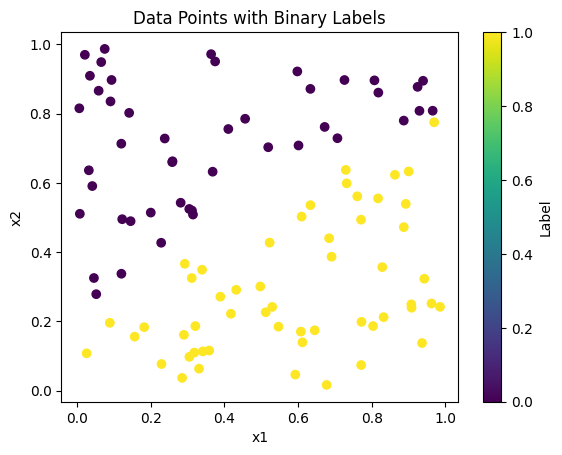

In [84]:
np.random.seed(42)  # For reproducibility

# Create the dataset
num_data_pts = 100
X = np.random.rand(num_data_pts, 2)
y = np.array([assign_binary_label(x1, x2) for x1, x2 in X])

# Plot the data (using the original shape of X)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Data Points with Binary Labels')
plt.colorbar(label='Label')
plt.show()

Initialize parameters - number of neurons in all layers and initialise weights and biases

In [85]:
input_size = 2
hidden_layer_size = 3
output_size = 1

#this is a fully connected network so each node has a connection all other nodes

# Initialize weights and biases
np.random.seed(42)  # For reproducibility
weights = {
    "W1": np.random.rand(hidden_layer_size, input_size),
    "W2": np.random.rand(output_size, hidden_layer_size)
}
biases = {
    "b1": np.zeros((hidden_layer_size, 1)),
    "b2": np.zeros((output_size, 1))
}

Define activation functions to introduce non-linearity into the network
- Let´s use ReLU in the hidden layers for better performance and faster convergence
- Let´s use the sigmoid function in the output layer as it is a binary classification problem

Let´s start by implementing the sigmoid function - this is a function that maps any input value to a value between 0 and 1. It is commonly used in the output of binary classification problems. 

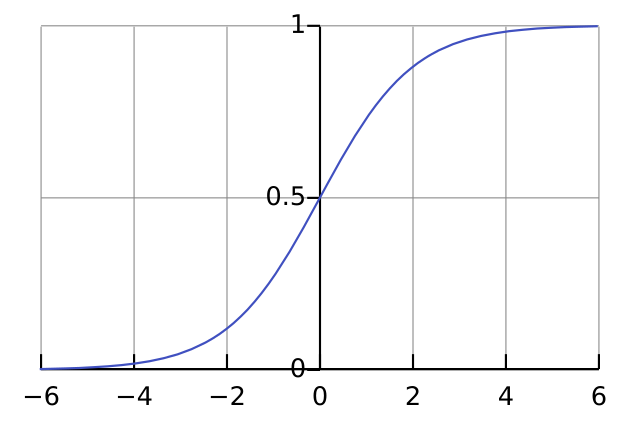

In [86]:
import math

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

We now implement a function to calculate the derivative of the sigmoid function - as it is used in backpropagation. We use the derivative function to help in calculating the gradient of the loss with respect to the weights. 

In [87]:
def sigmoid_derivative(z):
    return sigmoid(z) * (1 - sigmoid(z))

The ReLU (Rectified Linear Unit) function is an activation function that output the original input if it is positive, and 0 otherwise. 
The output of the ReLU ranges from 0 to infinity. It is commonly used in the hidden layers of neural networks as it helps mitigate the vanishing gradient problem and allows for faster training. 

In [88]:
def relu(x):
    return max(x,0)

To calculate the derivative of the ReLU we need to take two cases into account - first if x is positive and second if it is negative. 

In [89]:
def relu_derivative(x):
    if x > 0: #in this region relu(x) = x
        return 1
    else: #in this region relu(x) = 0
        return 0

Let´s now implement a softmax layer function for the final layer to calculate the output probabilities (use this one when there are more than 2 classes, so that all probabilities add up to 1)

In [90]:
from numpy import exp
def softmax(vector):
 e = exp(vector)
 return e / e.sum()


Now let´s write some code to pass the data through the network from the input layer to the output layer - this is called the forward pass

In [91]:
def forward_pass(x, weights, biases, activation_fns, num_layers):
    #store linear transformations zs and activations
    zs = []
    activations = []

    #input to the first layer
    a = x
    for l in range(1,num_layers+1):
        z = np.dot(weights[f"W{l}"], a) + biases[f"b{l}"]
        zs.append(z)
        a = activation_fns[l-1](z)
        activations.append(a)
    return zs, activations

We now move on to implementing a loss function. A loss function can tell us how well our network is computing the labels compared to the actual labels. This is a supervised classification problem as we already have the labels so at the end of the forward pass we can see how well our network did in predicting the actual labels. 

For binary classification we often use binary cross-entropy loss

The binary cross-entropy loss for a single sample is given by:
L(actual, predicted) = actual*log(predicted) - (1-actual) * log(1-predicted)

For the whole dataset we compute the average loss based on how the network predicted each single point

In [92]:
#binary cross entropy loss for a single data point
def binary_cross_entropy_loss(y_true, y_predicted):
    # Clip predicted value to avoid log(0)
    very_small_number = 1e-7
    y_predicted = np.clip(y_predicted, very_small_number, 1 - very_small_number)
    
    # Calculate binary cross-entropy for a single point
    loss = - (y_true * np.log(y_predicted) + (1 - y_true) * np.log(1 - y_predicted))
    
    return loss

So we now have an estimate for how well or bad the network did in predicting the true output for each point. Let´s say it did quite poorly and we want to improve the performance. What we mean by the network doing "poorly" is that the weights and biases were poorly configured to this particular dataset or problem and we need to tune them a bit so that the prediction error decreases. We do this through a process called backpropagation. This is where we figure out how to take the error or the loss and tune the weights and biases by going backwards from the output layer to the input layer. We "propagate" the error backwards. 

For each layer we calculate how much each weight and each bias contributed to the error. These contributions are called gradients. Finally we adjust the weights and biases in the opposite direction of the gradients in order to reduce the error. We start by calculating the gradients for the output layer. 

To calculate the gradients for the output layer we first calculate the error between the prediction and the actual value. 

In [93]:
#this is also called the cost of a single training example 
def output_layer_error(actual, predicted):
    return predicted - actual

We now move on to analyzing the weights in the hidden layer just before the output layer. Remember that we needed to know how each weight an each bias contributed to the error. This is what the gradient can tell us. The gradient can tell us how much a small change in each weight will affect the error.

Let´s try to paint a more visual picture of how the gradient works. Imagine that you´re standing on a mountain and you want to reach the lowest point in the valley as quickly as possible. Ideally you would want to find the steepest slope and go in that direction. The gradient tells us the slope if we take a small step in some direction. If we think of this in terms of loss we can imagine that each point on the mountain is possible values that the loss function can take and the gradient can tell us the gradient in which direction we should go, which also tells us how to change each weight and bias, to reduce the loss. 

But how can calculating the gradient in terms of the loss function tell us how we should tweak our weights and biases? The key mathematical concept used in backpropagation is the chain rule of calculus. The chain rule allows us to compue the derivative of a composition of functions. The loss function is a function of a network´s output, which is a function of the weights and biases. 

In [94]:
def backward_pass(x, y, weights, biases, zs, activations, activation_fns, activation_derivative_fns):
    n = len(y)  # Number of examples
    num_layers = len(weights)  # Number of layers in the network
    
    # Initialize dictionaries to store gradients
    grads = {}
    
    # Initialize the error at the output layer (delta for the last layer)
    output_error = activations[-1] - y  # Error in the output layer (aL - y)
    
    # Loop backward through layers
    for l in reversed(range(1, num_layers + 1)):
        # dWl and dbl for current layer
        a_prev = activations[l - 1] if l > 1 else x  # Activation from the previous layer (or input layer)
        z_curr = zs[l - 1]  # Current z (before applying activation)
        
        # Compute gradients for weights and biases
        dWl = (1 / n) * np.dot(output_error, a_prev.T)
        dbl = (1 / n) * np.sum(output_error, axis=1, keepdims=True)
        
        # Store gradients in the dictionary
        grads[f"dW{l}"] = dWl
        grads[f"db{l}"] = dbl
        
        if l > 1:
            # Propagate error backwards
            dz_prev = np.dot(weights[f"W{l}"].T, output_error) * activation_derivative_fns[l-1](z_curr)
            output_error = dz_prev  # Update error for next layer
    
    return grads

Now let´s tie it all together so that we´re able to train our neural network 

In [95]:
def update_parameters(weights, biases, grads, learning_rate):
    for i in range(1, len(weights)+1):
        weights[f"W{i}"] -= learning_rate * grads[f"dW{i}"]
        biases[f"b{i}"] -= learning_rate * grads[f"db{i}"]

    return weights, biases

In [96]:
def train_neural_network(x, y, weights, biases, learning_rate, iterations, activation_fns, activation_derivative_fns):
    num_layers = len(weights)
    for iteration in range(iterations):
        # Forward pass
        zs, activations = forward_pass(x, weights, biases, activation_fns, num_layers)

        a_final = activations[-1]
        
        # Compute loss per sample
        individual_losses = []

        #loop through all samples
        for i in range(len(y)):
            loss = binary_cross_entropy_loss(y[i],a_final[0][i])
            individual_losses.append(loss)

        # Calculate the average loss after each iteration
        avg_loss = np.mean(individual_losses)
        if iteration % 1000 == 0:  # Print every 1000 iterations for example
            print(f"Iteration {iteration}, Average Loss: {avg_loss}")
        
        # Backward pass
        grads = backward_pass(x, y, weights, biases, zs, activations, activation_fns, activation_derivative_fns)
        
        # Update parameters
        weights, biases = update_parameters(weights, biases, grads, learning_rate)
    
    return weights, biases

In [97]:
#train and test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [98]:
# Prepare X and y for the neural network (transposed for matrix operations)
X_train = X_train.T  # Shape (2, num_data_pts)
y_train = y_train.T  # Shape (1, num_data_pts)
learning_rate = 0.1
iterations = 10000
activation_fns = [sigmoid, sigmoid]
activation_derivative_fns = [sigmoid_derivative, sigmoid_derivative]
num_layers = len(weights)
weights, biases = train_neural_network(X_train, y_train, weights, biases, learning_rate, iterations, activation_fns, activation_derivative_fns)

# Test the network
zs,activations = forward_pass(X_test.T, weights, biases, activation_fns, num_layers)
final_output = activations[-1]

Iteration 0, Average Loss: 0.8232426399586699
Iteration 1000, Average Loss: 0.6218023803213918
Iteration 2000, Average Loss: 0.34032500804009735
Iteration 3000, Average Loss: 0.1710747156074601
Iteration 4000, Average Loss: 0.11044832942155364
Iteration 5000, Average Loss: 0.08309775615314155
Iteration 6000, Average Loss: 0.0677917644876055
Iteration 7000, Average Loss: 0.057951888946793054
Iteration 8000, Average Loss: 0.051005717757387346
Iteration 9000, Average Loss: 0.04576935771187337


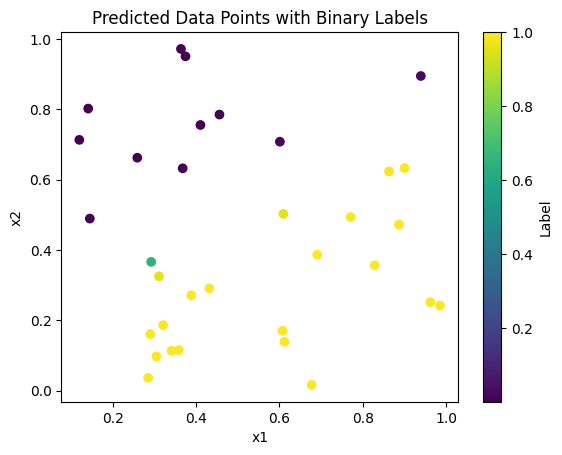

In [99]:
# plot predicted
plt.scatter(X_test[:, 0], X_test[:, 1], c=final_output, cmap='viridis')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Predicted Data Points with Binary Labels')
plt.colorbar(label='Label')
plt.show()

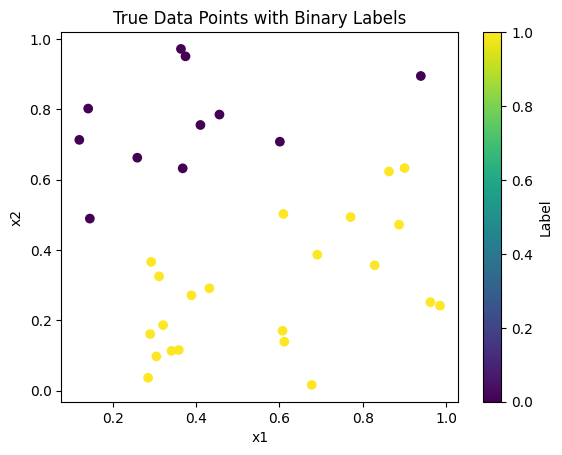

In [100]:
#plot actual
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='viridis')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('True Data Points with Binary Labels')
plt.colorbar(label='Label')
plt.show()